# **Prepare**

## Import

In [73]:
import warnings

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go


import statsmodels.formula.api as smf
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from sklearn import tree, metrics
from scipy.stats import norm 
from scipy import stats, integrate
import matplotlib.pyplot as plt
from IPython.display import HTML
import folium
from folium.plugins import HeatMap
from math import sqrt



from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import *
from sklearn.pipeline import *
from sklearn.utils.validation import check_is_fitted
import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter(action="ignore", category=FutureWarning)

In [147]:
def wrangle(path):
    # Read csv file into dataframe
    df = pd.read_csv(path)

    # Select the features
    # df = df[[ 'YEAR', 'DATE', 'TIME', 'HOUR', 'STREET1', 'STREET2', 'ROAD_CLASS', 'DISTRICT', 'LOCCOORD', 'ACCLOC', 'TRAFFCTL', 'VISIBILITY', 'LIGHT',
    # 'RDSFCOND', 'ACCLASS', 'IMPACTYPE', 'INVTYPE', 'INVAGE', 'INJURY', 'INITDIR', 'VEHTYPE', 'MANOEUVER', 'DRIVACT', 'DRIVCOND', 'PEDTYPE', 'PEDACT', 
    # 'PEDCOND',  'PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK','TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT',
    # 'ALCOHOL', 'DISABILITY', 'POLICE_DIVISION','NEIGHBOURHOOD']]
    ## Dropping columns where missing values were greater than 80%
    df = df.drop(["PEDTYPE", "PEDACT", "PEDCOND"], axis=1)
    # Changing the property damage and non-fatal columns to Non-Fatal
    df['ACCLASS'] = np.where(df['ACCLASS'] == 'Property Damage Only', 'Non-Fatal', df['ACCLASS'])
    df['ACCLASS'] = np.where(df['ACCLASS'] == 'Non-Fatal Injury', 'Non-Fatal', df['ACCLASS'])
    
    df['MONTH'] = pd.to_datetime(df['DATE']).dt.month
    df['MONTH_NAME'] = pd.to_datetime(df['DATE']).dt.month_name()
    df['DAY'] = pd.to_datetime(df['DATE']).dt.day
    df['MINUTES'] = pd.to_datetime(df['DATE']).dt.minute


    return df    

In [148]:
path = 'data/KSI.csv'
df = wrangle(path)
print(df.shape)

(16860, 58)


In [149]:
df.head()

,X,Y,INDEX_,ACCNUM,YEAR,DATE,TIME,HOUR,STREET1,STREET2,...,ALCOHOL,DISABILITY,POLICE_DIVISION,HOOD_ID,NEIGHBOURHOOD,ObjectId,MONTH,MONTH_NAME,DAY,MINUTES
0,-8.844611e+06,5.412414e+06,3387730,892658,2006,2006/03/11 05:00:00+00,852,8,BLOOR ST W,DUNDAS ST W,...,No,No,D11,88,High Park North (88),1,3,March,11,0
1,-8.844611e+06,5.412414e+06,3387731,892658,2006,2006/03/11 05:00:00+00,852,8,BLOOR ST W,DUNDAS ST W,...,No,No,D11,88,High Park North (88),2,3,March,11,0
2,-8.816480e+06,5.434843e+06,3388101,892810,2006,2006/03/11 05:00:00+00,915,9,MORNINGSIDE AVE,SHEPPARD AVE E,...,No,No,D42,131,Rouge (131),3,3,March,11,0
3,-8.816480e+06,5.434843e+06,3388102,892810,2006,2006/03/11 05:00:00+00,915,9,MORNINGSIDE AVE,SHEPPARD AVE E,...,No,No,D42,131,Rouge (131),4,3,March,11,0
4,-8.822759e+06,5.424516e+06,3387793,892682,2006,2006/03/12 05:00:00+00,240,2,EGLINTON AVE E,COMMONWEALTH AVE,...,Yes,No,D41,138,Eglinton East (138),5,3,March,12,0


In [151]:
df.describe()

,X,Y,INDEX_,ACCNUM,YEAR,TIME,HOUR,LATITUDE,LONGITUDE,HOOD_ID,ObjectId,MONTH,DAY,MINUTES
count,1.686000e+04,1.686000e+04,1.686000e+04,1.686000e+04,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.0
mean,-8.838272e+06,5.420819e+06,3.475220e+07,2.263460e+09,2012.256168,1352.106821,13.241103,43.710920,-79.395546,74.003618,8430.500000,6.802610,15.617023,0.0
std,1.159490e+04,8.664361e+03,3.657126e+07,3.263836e+09,4.252797,629.726747,6.302679,0.056254,0.104159,41.411541,4867.207105,3.288337,8.847798,0.0
min,-8.865305e+06,5.402256e+06,3.363207e+06,2.530100e+04,2006.000000,0.000000,0.000000,43.590289,-79.638390,1.000000,1.000000,1.000000,1.000000,0.0
25%,-8.846402e+06,5.413345e+06,5.358714e+06,1.065135e+06,2009.000000,913.000000,9.000000,43.662398,-79.468578,39.000000,4215.750000,4.000000,8.000000,0.0
50%,-8.838358e+06,5.419639e+06,7.474276e+06,1.293196e+06,2012.000000,1442.000000,14.000000,43.703284,-79.396323,77.000000,8430.500000,7.000000,16.000000,0.0
75%,-8.829527e+06,5.427906e+06,8.063194e+07,5.001806e+09,2016.000000,1845.000000,18.000000,43.756945,-79.316990,112.000000,12645.250000,10.000000,23.000000,0.0
max,-8.808254e+06,5.443099e+06,8.154201e+07,9.085345e+09,2020.000000,2359.000000,23.000000,43.855445,-79.125896,140.000000,16860.000000,12.000000,31.000000,0.0


## Explore

### 1. Changing the property damage and non-fatal columns to Non-Fatal

In [152]:
df['ACCLASS'] = np.where(df['ACCLASS'] == 'Property Damage Only', 'Non-Fatal', df['ACCLASS'])
df['ACCLASS'] = np.where(df['ACCLASS'] == 'Non-Fatal Injury', 'Non-Fatal', df['ACCLASS'])
df.ACCLASS.unique()

array(['Fatal', 'Non-Fatal'], dtype=object)

### 2. Accident numbers against years and months

MONTH_NAME
April        403
August       587
December     468
February     363
January      429
July         533
June         597
March        409
May          488
November     530
October      585
September    610
Name: ACCNUM, dtype: int64

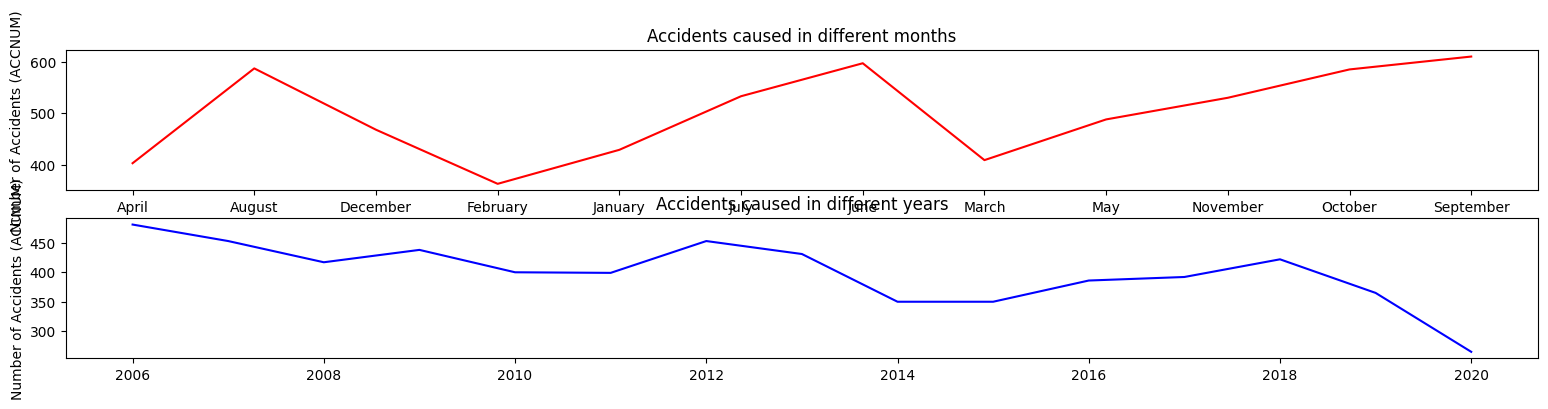

In [167]:
# #Number of Unique accidents by Year
Year_accident = df.groupby('YEAR')['ACCNUM'].nunique().sort_index(ascending=True)
Month_accident = df.groupby('MONTH_NAME')['ACCNUM'].nunique().sort_index(ascending=True)

fig, ax = plt.subplots(2,1,figsize=(19,4))


ax[1].set_title("Accidents caused in different years")
ax[1].set_ylabel('Number of Accidents (ACCNUM)')
ax[1].plot(Year_accident, color='blue')


ax[0].set_title("Accidents caused in different months")
ax[0].set_ylabel('Number of Accidents (ACCNUM)')
ax[0].plot(Month_accident, color='red')

plt.show()

### 3. Fatality Heatmap of those that where Fatally Injured

In [145]:
df_Fatal = df[df['INJURY'] == 'Fatal']
df_Fatal = df_Fatal[['LATITUDE', 'LONGITUDE']]
lat_Toronto_1 = df_Fatal.describe().at['mean','LATITUDE']
lng_Toronto_1 = df_Fatal.describe().at['mean','LONGITUDE']
Toronto_location_F = [lat_Toronto_1, lng_Toronto_1]
Fatal_map_F = folium.Map(Toronto_location_F, zoom_start=10.255)
HeatMap(df_Fatal.values, min_opacity =0.3).add_to(Fatal_map_F)
Fatal_map_F



### 4. Fatality Heatmap of those that where not Fatally Injured

In [146]:
df_Non_Fatal = df[df['INJURY'] != 'Fatal']
df_Non_Fatal = df_Non_Fatal[['LATITUDE', 'LONGITUDE']]
lat_Toronto_2 = df_Non_Fatal.describe().at['mean','LATITUDE']
lng_Toronto_2 = df_Non_Fatal.describe().at['mean','LONGITUDE']
Toronto_location_N = [lat_Toronto_2, lng_Toronto_2]
Fatal_map_N = folium.Map(Toronto_location_F, zoom_start=10.255)
HeatMap(df_Fatal.values, min_opacity =0.3).add_to(Fatal_map_N)
Fatal_map_N

### 5. Fatality over years (# of people died)

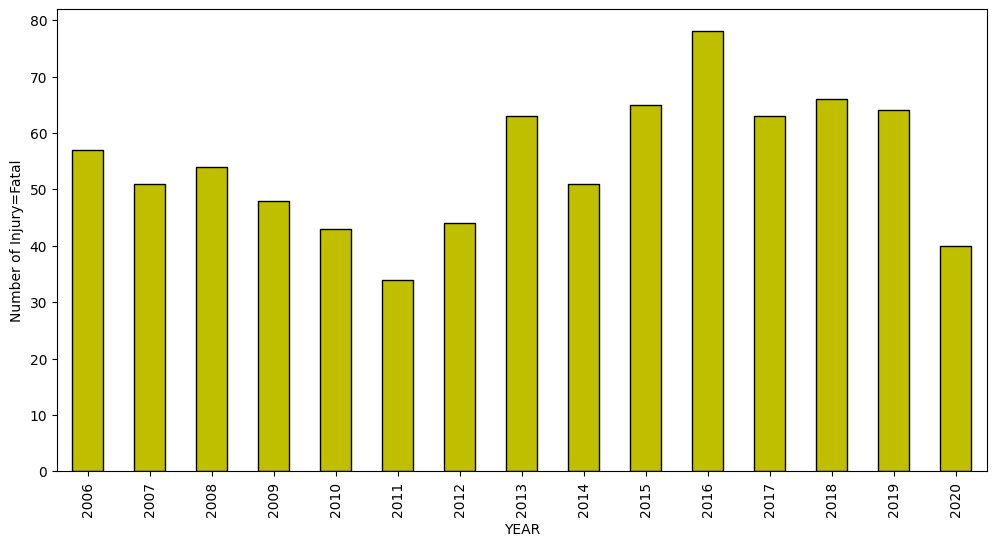

In [105]:
#Lets look at Fatality over years (# of people died)
Fatality = df[df['INJURY'] =='Fatal']
Fatality = Fatality.groupby(df['YEAR']).count()
plt.figure(figsize=(12,6))


plt.ylabel('Number of Injury=Fatal')
Fatality['INJURY'].plot(kind='bar',color="y" , edgecolor='black')

plt.show()

### 6. Looking at area where accident happens



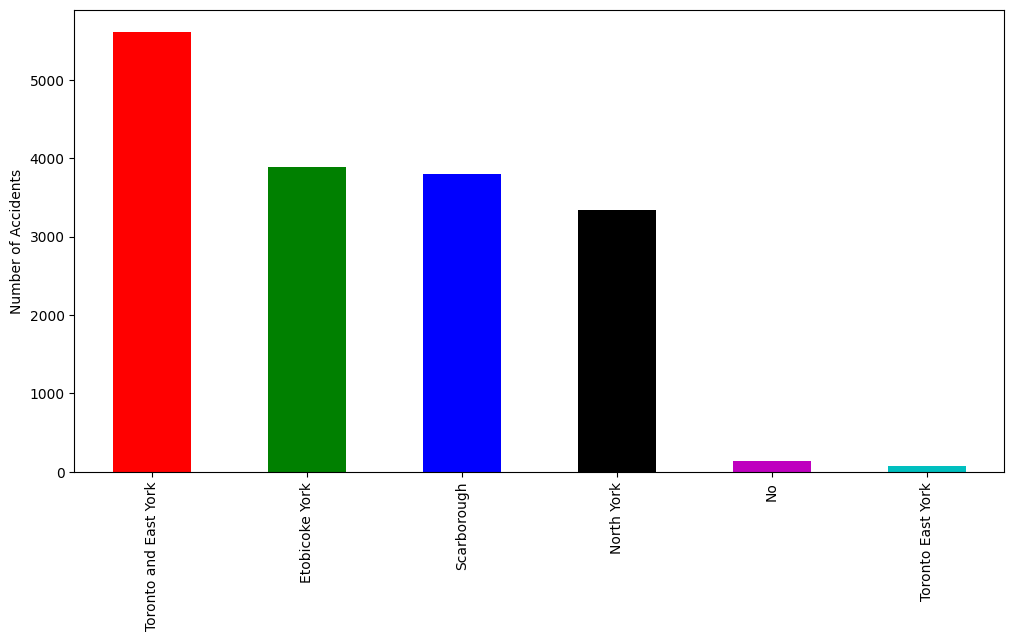

In [108]:
Region_df = df['DISTRICT'].value_counts()
plt.figure(figsize=(12,6))
plt.ylabel('Number of Accidents')
Region_df.plot(kind='bar',color=list('rgbkmc') )
plt.show()

### 7. 

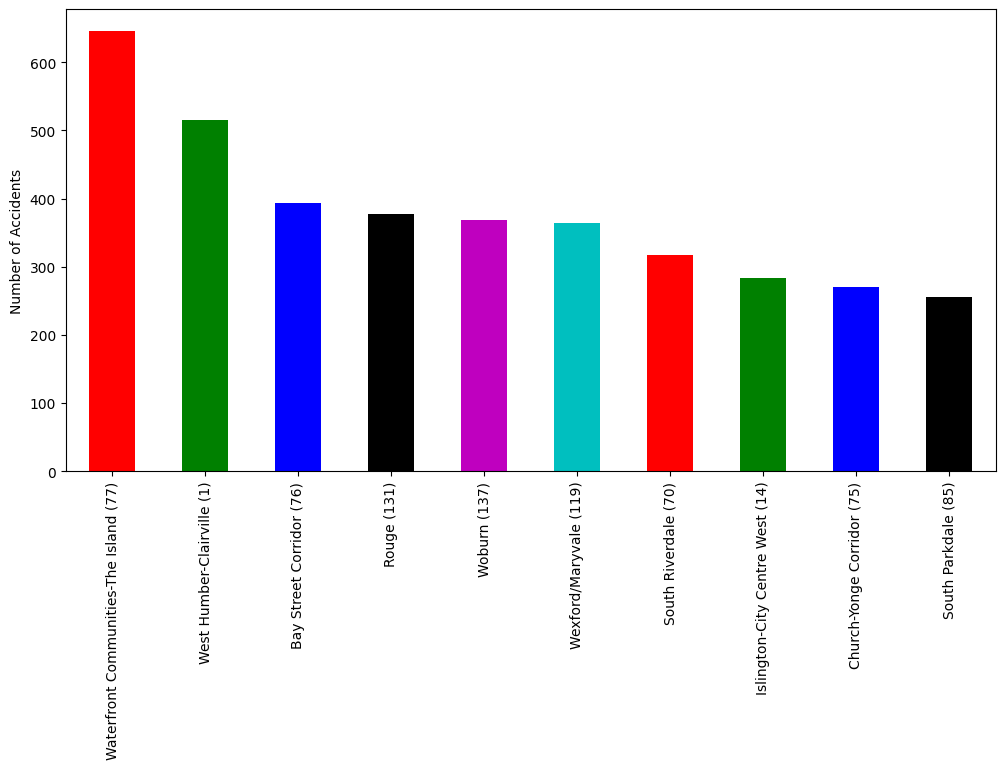

In [111]:
Hood_df = df['NEIGHBOURHOOD'].value_counts()
plt.figure(figsize=(12,6))
plt.ylabel('Number of Accidents')
Hood_df.nlargest(10).plot(kind='bar',color=list('rgbkmc') )
plt.show()

In [37]:
def conut_feature(df, xlabel, title):
    ax = sns.countplot(x=df)

    plt.xticks(size=12)
    plt.xlabel(xlabel, size=14)
    plt.yticks(size=12)
    plt.ylabel('Number of Traffic Collisions', size=12)
    plt.title(title, size=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

    total = len(df)
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.2f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')
    plt.tight_layout()
    plt.show()

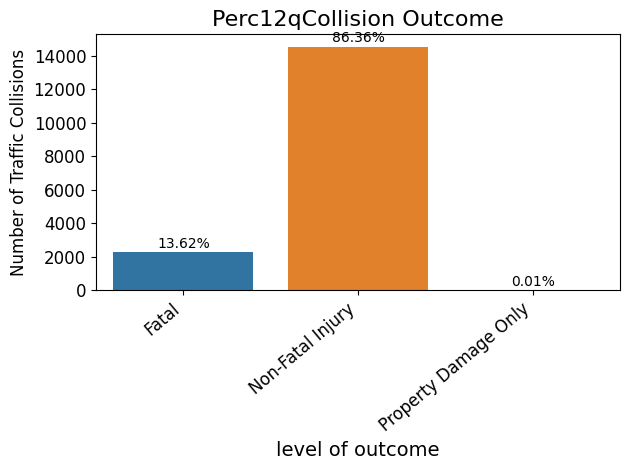

In [38]:
# What is the percentage of OUTCOME?
conut_feature(df['ACCLASS'], 'level of outcome', 'Perc12qCollision Outcome')

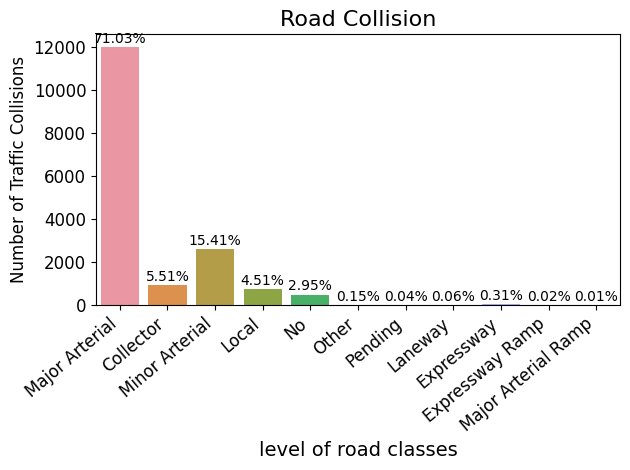

In [127]:

conut_feature(df['ROAD_CLASS'], 'level of road classes','Road Collision')


In [135]:
df_clean_data = df[['ACCNUM', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTES', 'WEEKDAY', 'LATITUDE', 'LONGITUDE', 
'DISTRICT', 'VISIBILITY', 'LIGHT', 'RDSFCOND', 'PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 
    'TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY', 'ACCLASS']]


KeyError: "['MONTH', 'DAY', 'MINUTES', 'WEEKDAY'] not in index"

#### Remove low and high cardinality 

In [16]:
# low and high cardinality
low_high = [ 'YEAR', 'DATE', 'TIME', 'STREET1', 'STREET2', 'NEIGHBOURHOOD']

df = df.drop(low_high, axis=1)


#### Encoding

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in df.select_dtypes('object').columns:

    df[col] = le.fit_transform(df[col])

## Split

In [18]:
target = 'ACCLASS'
X = df.drop(target, axis=1)
y = df[target]

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# **Build Model**

## Model 1 - XGBoost Classifier

In [24]:
model_1 = make_pipeline(
    SimpleImputer(),
    XGBClassifier(),
)
model_1.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto', ...))])

In [26]:
model_1_pred = model_1.predict(X_test)
model_1_acc = accuracy_score(y_test, model_1_pred)
print(f'Model Accuracy: {model_1_acc}')
print(classification_report(y_test, model_1_pred))

Model Accuracy: 0.9286279161724001
              precision    recall  f1-score   support

           0       0.89      0.56      0.69       713
           1       0.93      0.99      0.96      4345

    accuracy                           0.93      5058
   macro avg       0.91      0.77      0.82      5058
weighted avg       0.93      0.93      0.92      5058



## Model 2 - Suppor Vector Classifier

In [36]:
from sklearn.svm import SVC
model_2 = make_pipeline(
    SimpleImputer(),
    SVC()
)
model_2.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()), ('svc', SVC())])

In [37]:
model_2_pred = model_2.predict(X_test)
model_2_acc = accuracy_score(y_test, model_3_pred)
print(f'Model Accuracy: {model_2_acc}')
print(classification_report(y_test, model_2_pred))

Model Accuracy: 0.8590351917754053
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       713
           1       0.86      1.00      0.92      4345

    accuracy                           0.86      5058
   macro avg       0.43      0.50      0.46      5058
weighted avg       0.74      0.86      0.79      5058



C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: Undefin

## Evaluate

In [38]:
names = ['XGBClassifier', 'Support Vector Classifier']
acc_score = [model_1_acc, model_2_acc]
models = pd.DataFrame()
models['Models'] = names
models['Accuracy'] = acc_score

In [39]:
models.head()

,Models,Accuracy
0,XGBClassifier,0.928628
1,Support Vector Classifier,0.859035


<AxesSubplot:xlabel='Models', ylabel='Accuracy'>

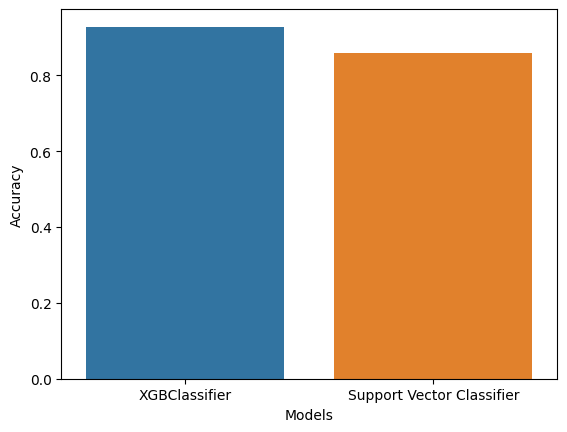

In [41]:
sns.barplot(x='Models', y='Accuracy', data=models)